<a href="https://colab.research.google.com/github/Sutharsanababu/CODSOFT-Python-task/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import time, psutil, os, gc
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from tqdm.contrib import itertools

In [19]:
start = time.time()
process = psutil.Process(os.getpid())

In [20]:
data = pd.read_csv('/content/creditcard.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()

Memory usage         67.36 MB
Dataset shape    (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
data_0, data_1 = data[data['Class'] == 0], data[data['Class'] == 1]
X_0, y_0 = data_0.drop('Class', axis = 1), data_0['Class']
X_1, y_1 = data_1.drop('Class', axis = 1), data_1['Class']
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, test_size = 0.2, random_state = 40)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val_1, data_test_1 = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = train_test_split(X_1, y_1, test_size = 0.5, random_state = 40)
data_val_2, data_test_2 = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)
data_val, data_test = pd.concat([data_val_1, data_val_2], axis = 0), pd.concat([data_test_1, data_test_2], axis = 0)
X_val, y_val = data_val.drop('Class', axis = 1), data_val['Class']
X_test, y_test = data_test.drop('Class', axis = 1), data_test['Class']


In [22]:
labels = ['Train', 'Validation', 'Test']
values_0 = [len(y_train[y_train == 0]), len(y_val[y_val == 0]), len(y_test[y_test == 0])]
values_1 = [len(y_train[y_train == 1]), len(y_val[y_val == 1]), len(y_test[y_test == 1])]
fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'domain'}, {'type': 'domain'}]])
fig.add_trace(go.Pie(values = values_0, labels = labels, hole = 0.5, textinfo = 'percent', title = "Authentic"),
              row = 1, col = 1)
fig.add_trace(go.Pie(values = values_1, labels = labels, hole = 0.5, textinfo = 'percent', title = "Fraudulent"),
              row = 1, col = 2)
text_title = "Distribution of authentic and fraudulent transactions over training, validation and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95))
fig.show()

In [13]:
bins_train = math.floor(len(X_train)**(1/3))

In [14]:
for df in [X_train, X_val, X_test]:
    df['Day'], temp = df['Time'] // (24*60*60), df['Time'] % (24*60*60)
    df['Hour'], temp = temp // (60*60), temp % (60*60)
    df['Minute'], df['Second'] = temp // 60, temp % 60
X_train[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()

,Time,Day,Hour,Minute,Second
19594,30401.0,0.0,8.0,26.0,41.0
124712,77397.0,0.0,21.0,29.0,57.0
167920,118964.0,1.0,9.0,2.0,44.0
47377,43191.0,0.0,11.0,59.0,51.0
41731,40804.0,0.0,11.0,20.0,4.0


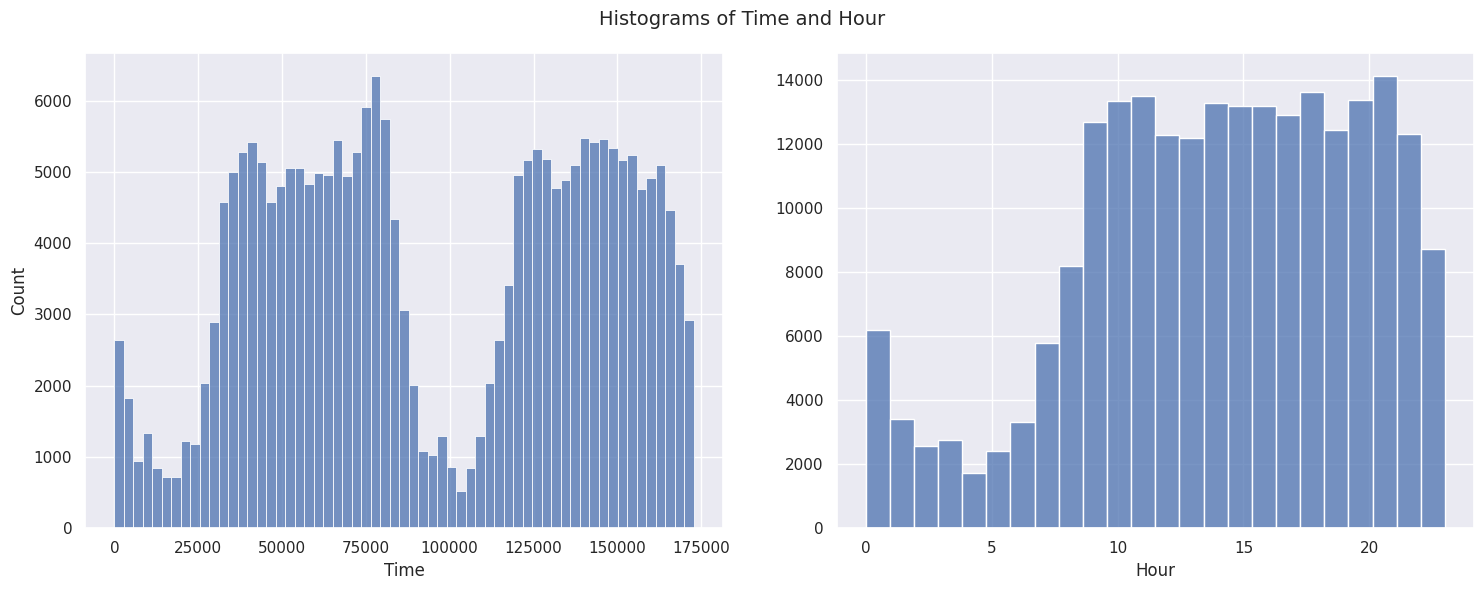

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(data = X_train, x = 'Time', bins = bins_train, ax = ax[0])
sns.histplot(data = X_train, x = 'Hour', bins = 24, ax = ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Time and Hour", size = 14)
plt.tight_layout()
plt.show()

In [23]:
for df in [X_train, X_val, X_test]:
    df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)

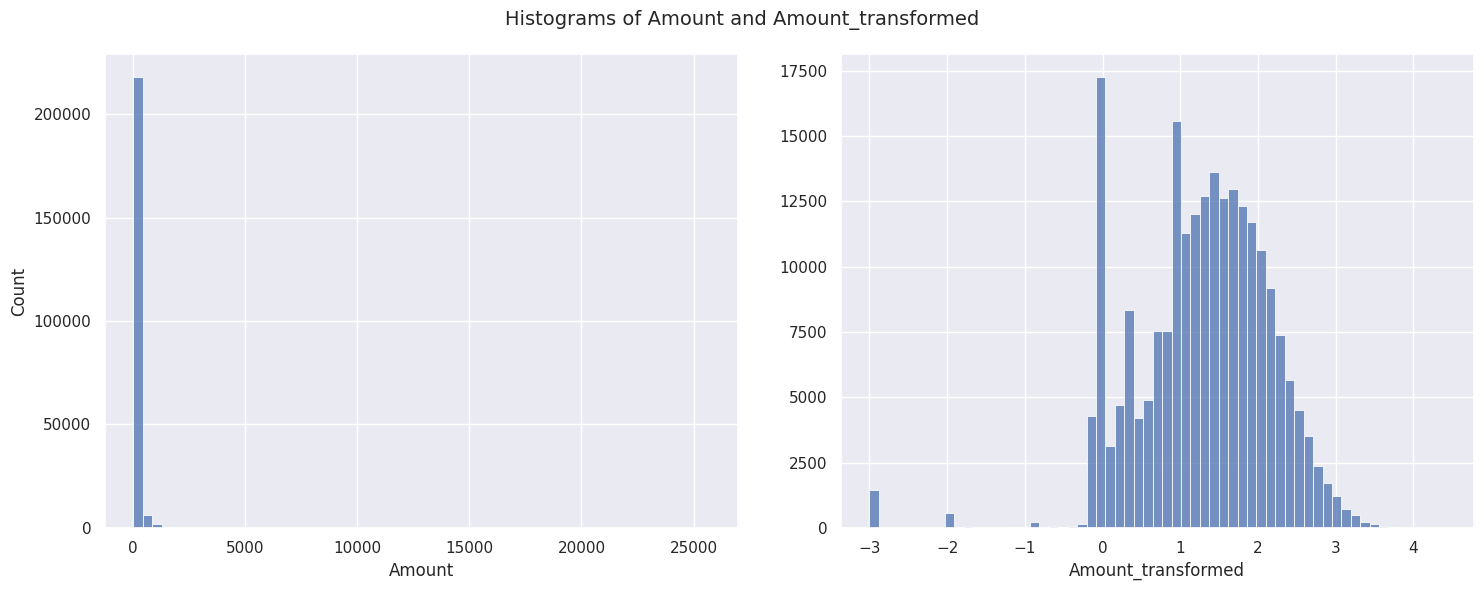

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(data = X_train, x = 'Amount', bins = bins_train, ax = ax[0])
sns.histplot(data = X_train, x = 'Amount_transformed', bins = bins_train, ax = ax[1])
ax[1].set_ylabel(" ")
plt.suptitle("Histograms of Amount and Amount_transformed", size = 14)
plt.tight_layout()
plt.show()

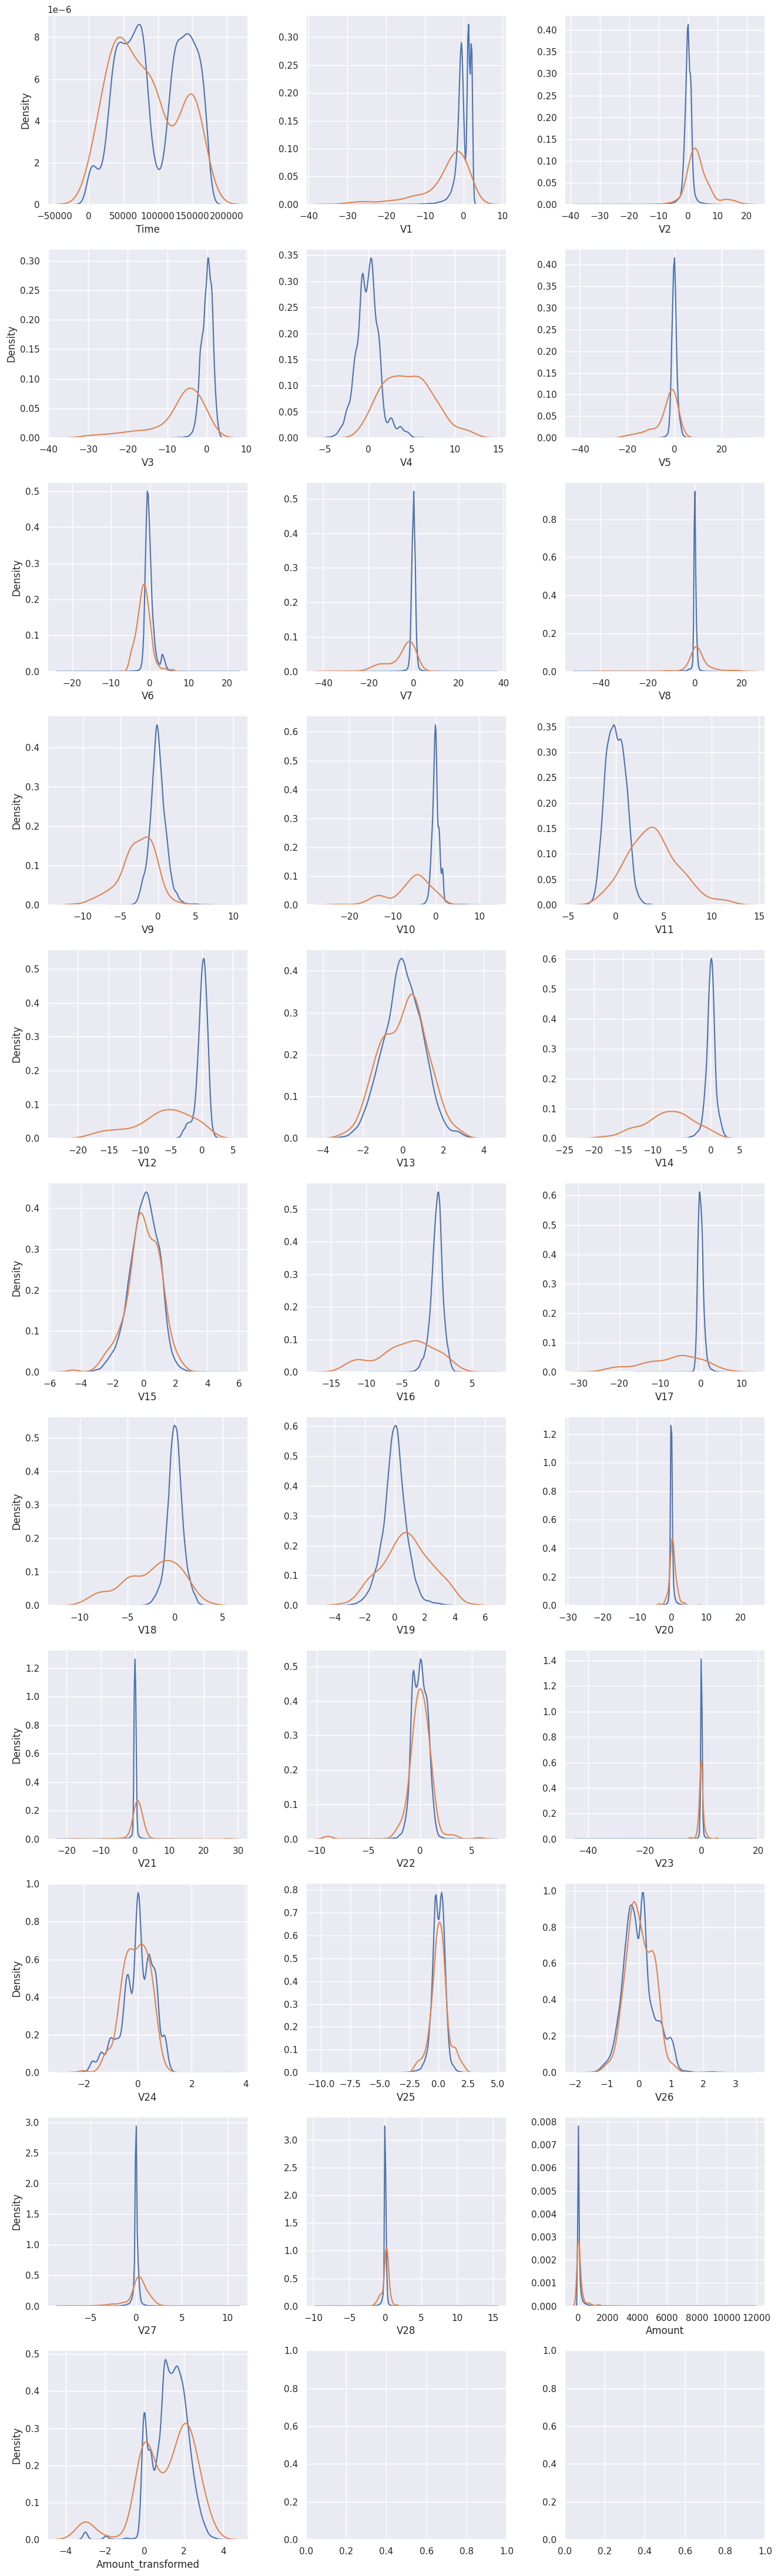

In [28]:
data_val = pd.concat([X_val, y_val], axis = 1)
data_val_0, data_val_1 = data_val[data_val['Class'] == 0], data_val[data_val['Class'] == 1]
cols, ncols = list(X_val.columns), 3
nrows = math.ceil(len(cols) / ncols)
fig, ax = plt.subplots(nrows, ncols, figsize = (4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(data_val_0[cols[i]], ax = ax[i // ncols, i % ncols])
    sns.kdeplot(data_val_1[cols[i]], ax = ax[i // ncols, i % ncols])
    if i % ncols != 0:
        ax[i // ncols, i % ncols].set_ylabel(" ")
plt.tight_layout()
plt.show()

In [30]:
import pandas as pd
for df in [X_train, X_val, X_test]:
    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Hour'] = df['Time'].dt.hour

cols = ['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour']
X_train_fs, X_val_fs, X_test_fs = X_train[cols], X_val[cols], X_test[cols]
X_train_fs.head()

,V4,V11,V12,V14,V16,V17,V18,V19,Hour
19594,-0.706232,2.027925,0.535822,0.250769,0.773615,0.449717,-1.963208,0.613481,8
124712,1.474933,-1.154523,0.263527,0.316174,-1.029415,1.030772,-0.438839,0.529080,21
167920,4.840766,-2.242431,0.034829,-0.546349,-0.070375,1.033695,0.531801,1.215045,9
47377,0.565273,-0.157045,-0.548790,0.419194,0.183518,-0.681323,0.911357,1.318132,11
41731,-0.428860,-0.580964,-0.609099,-0.187948,1.226723,0.104368,-0.995711,0.420557,11


In [35]:
def normal_density(x, mu, sigma):
    """
    Computes univariate normal probability density function (pdf) with mean mu, standard deviation sigma
    Args:
      x (scalar)    : input observation
      mu (scalar)   : mean
      sigma (scalar): standard deviation (> 0)
    Returns:
      f (scalar): value of the univariate normal pdf
    """
    assert sigma > 0, "Standard deviation must be positive"
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)
    return f

In [36]:
def normal_product(x_vec, mu_vec, sigma_vec):
    """
    Computes product of univariate normal densities
    Args:
      x_vec (array_like, shape (n,))    : vector of input observations
      mu_vec (array_like, shape (n,))   : vector of means
      sigma_vec (array_like, shape (n,)): vector of standard deviations (> 0)
    Returns:
      f (scalar): product of univariate normal densities
    """
    assert min(sigma_vec) > 0, "Standard deviation must be positive"
    assert len(mu_vec) == len(x_vec), "Length of mean vector does not match length of input vector"
    assert len(sigma_vec) == len(x_vec), "Length of standard deviation vector does not match length of input vector"
    f = 1
    for i in range(len(x_vec)):
        f = f * normal_density(x_vec[i], mu_vec[i], sigma_vec[i])
    return f

In [37]:
mu_train, sigma_train = X_train_fs.mean().values, X_train_fs.std().values

In [38]:
def model_normal(X, epsilon):
    """
    Anomaly detection model
    Args:
      X (DataFrame, shape (m, n)): DataFrame of features
      epsilon (scalar)           : threshold density value (> 0)
    Returns:
      y (array_like, shape (m,)): predicted class labels
    """
    y = []
    for i in X.index:
        prob_density = normal_product(X.loc[i].tolist(), mu_train, sigma_train)
        y.append((prob_density < epsilon).astype(int))
    return y

In [39]:
def conf_mat(y_test, y_pred):
    """
    Computes confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      confusion_mat (array): A 2D array representing a 2x2 confusion matrix
    """
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat

In [40]:
def conf_mat_heatmap(y_test, y_pred):
    """
    Prints confusion matrix
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      Nothing, prints a heatmap representing a 2x2 confusion matrix
    """
    confusion_mat = conf_mat(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [41]:
def f2_score(y_test, y_pred):
    """
    Computes F2-score, given true and predicted binary (0 or 1) labels
    Args:
      y_test (array_like): true binary (0 or 1) labels
      y_pred (array_like): predicted binary (0 or 1) labels
    Returns:
      f2 (float): F2-score obtained from y_test and y_pred
    """
    confusion_mat = conf_mat(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    f2 = (5 * tp) / ((5 * tp) + (4 * fn) + fp)
    return f2

In [42]:
alpha_list, f2_list, f2_max, alpha_opt, y_val_pred_opt = [], [], 0.0, 0.0, np.zeros(len(y_val))
for alpha, j in itertools.product(np.arange(0.001, 0.051, 0.001), range(1)):
    y_val_pred = model_normal(X_val_fs, epsilon = alpha**X_val_fs.shape[1])
    f2 = f2_score(y_val, y_val_pred)
    alpha_list.append(alpha)
    f2_list.append(f2)
    if f2 > f2_max:
        alpha_opt = alpha
        y_val_pred_opt = y_val_pred
        f2_max = f2

  0%|          | 0/50 [00:00<?, ?it/s]

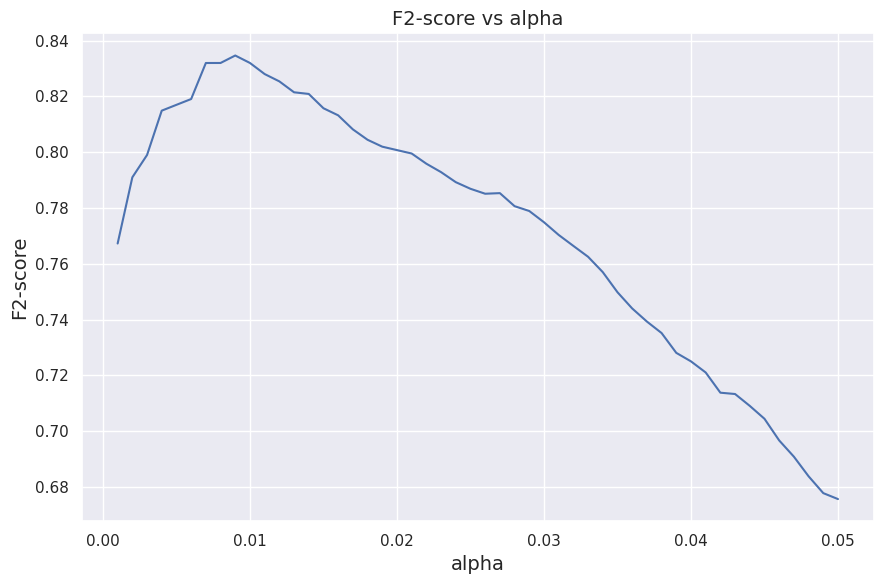

In [43]:
plt.figure(figsize = (9, 6))
plt.plot(alpha_list, f2_list)
plt.xlabel("alpha", fontsize = 14)
plt.ylabel("F2-score", fontsize = 14)
plt.title("F2-score vs alpha", fontsize = 14)
plt.tight_layout()
plt.show()

In [44]:
print(pd.Series({
    "Optimal alpha": alpha_opt,
    "Optimal F2-score": f2_score(y_val, y_val_pred_opt)
}).to_string())

Optimal alpha       0.009000
Optimal F2-score    0.834671


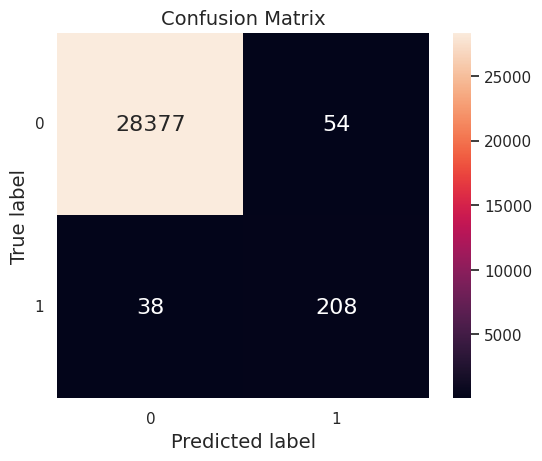

In [45]:
conf_mat_heatmap(y_val, y_val_pred_opt)

In [46]:
def evaluation(y_test, y_pred):
    confusion_mat = conf_mat(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    print(pd.Series({
        "Accuracy": (tp + tn) / (tn + fp + fn + tp),
        "Precision": tp / (tp + fp),
        "Recall": tp / (tp + fn),
        "F1-score": (2 * tp) / ((2 * tp) + fn + fp),
        "F2-score": (5 * tp) / ((5 * tp) + (4 * fn) + fp),
        "MCC": ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    }).to_string())

In [47]:
y_test_normal = model_normal(X_test_fs, epsilon = alpha_opt**X_test_fs.shape[1])
evaluation(y_test, y_test_normal)

Accuracy     0.996687
Precision    0.798419
Recall       0.821138
F1-score     0.809619
F2-score     0.816492
MCC          0.808030


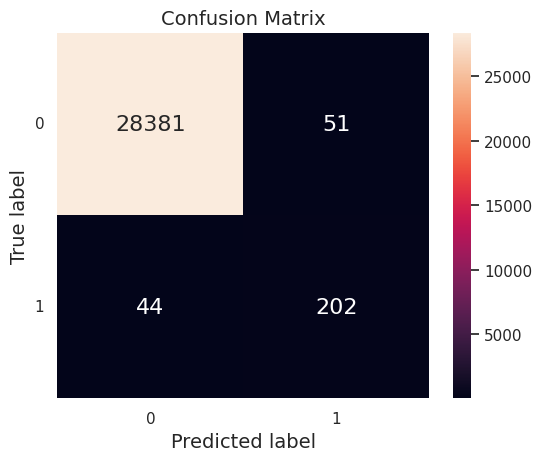

In [48]:
conf_mat_heatmap(y_test, y_test_normal)

In [49]:
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         1155.66 seconds
Process memory usage          876.30 MB
